In [1]:
suppressMessages(library(caret))
suppressMessages(library(lubridate))
suppressMessages(library(tidyverse))
suppressMessages(library(randomForest))

suppressMessages(library(openair))

In [2]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [3]:
# Working directory
setwd("~/Repositories/AirQualityCOVID")

load("data/data_AQ.rda")
load("data/meteorology.rda")

In [4]:
aq <- data_AQ[data_AQ$site == "es1580a", ] %>%
            filter(variable == "no2") %>%
            timeAverage(avg.time = "day")
aq$date <- as_date(aq$date)

mto <- data_Mto[data_Mto$site == "es1580a", ]

df <- merge(aq, mto,
              by = "date", all.x=T) %>%
        drop_na() %>%
        select(-date_end, -process, -summary, -validity, -site)

rm(data_AQ)
rm(data_Mto)
head(df)

,date,value,ws,wd,atmos_pres,tmed,prec,tmin,tmax,presMax,presMin,RH,solar.radiation
,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2013-01-01,14.91667,8.3500,286.6196,1019.650,11.6,5.5,10.6,12.6,1019.6,1007.3,88.11917,78.56742
2,2013-01-02,46.75000,5.7750,334.4606,1031.162,11.2,0.7,9.8,12.5,1028.7,1019.6,86.44662,60.13676
3,2013-01-03,38.66667,4.9500,104.8580,1037.925,10.8,0.0,8.4,13.2,1030.6,1028.7,85.19767,48.69664
4,2013-01-04,46.62500,3.5375,124.9080,1037.975,11.4,0.0,8.0,14.7,1031.2,1029.6,83.13043,81.60853
5,2013-01-05,38.29167,3.0000,124.7949,1035.957,9.1,0.0,7.7,10.5,1029.7,1027.6,89.72875,89.20845
6,2013-01-06,21.25000,3.6750,109.5865,1031.825,10.5,0.0,8.0,13.0,1027.7,1022.4,90.22318,86.77671


In [5]:
train <-  which(df$date < ymd("2020-01-01"))

In [6]:
df.data <- df %>%
        select(-date)
        data.frame()
time <- df$date

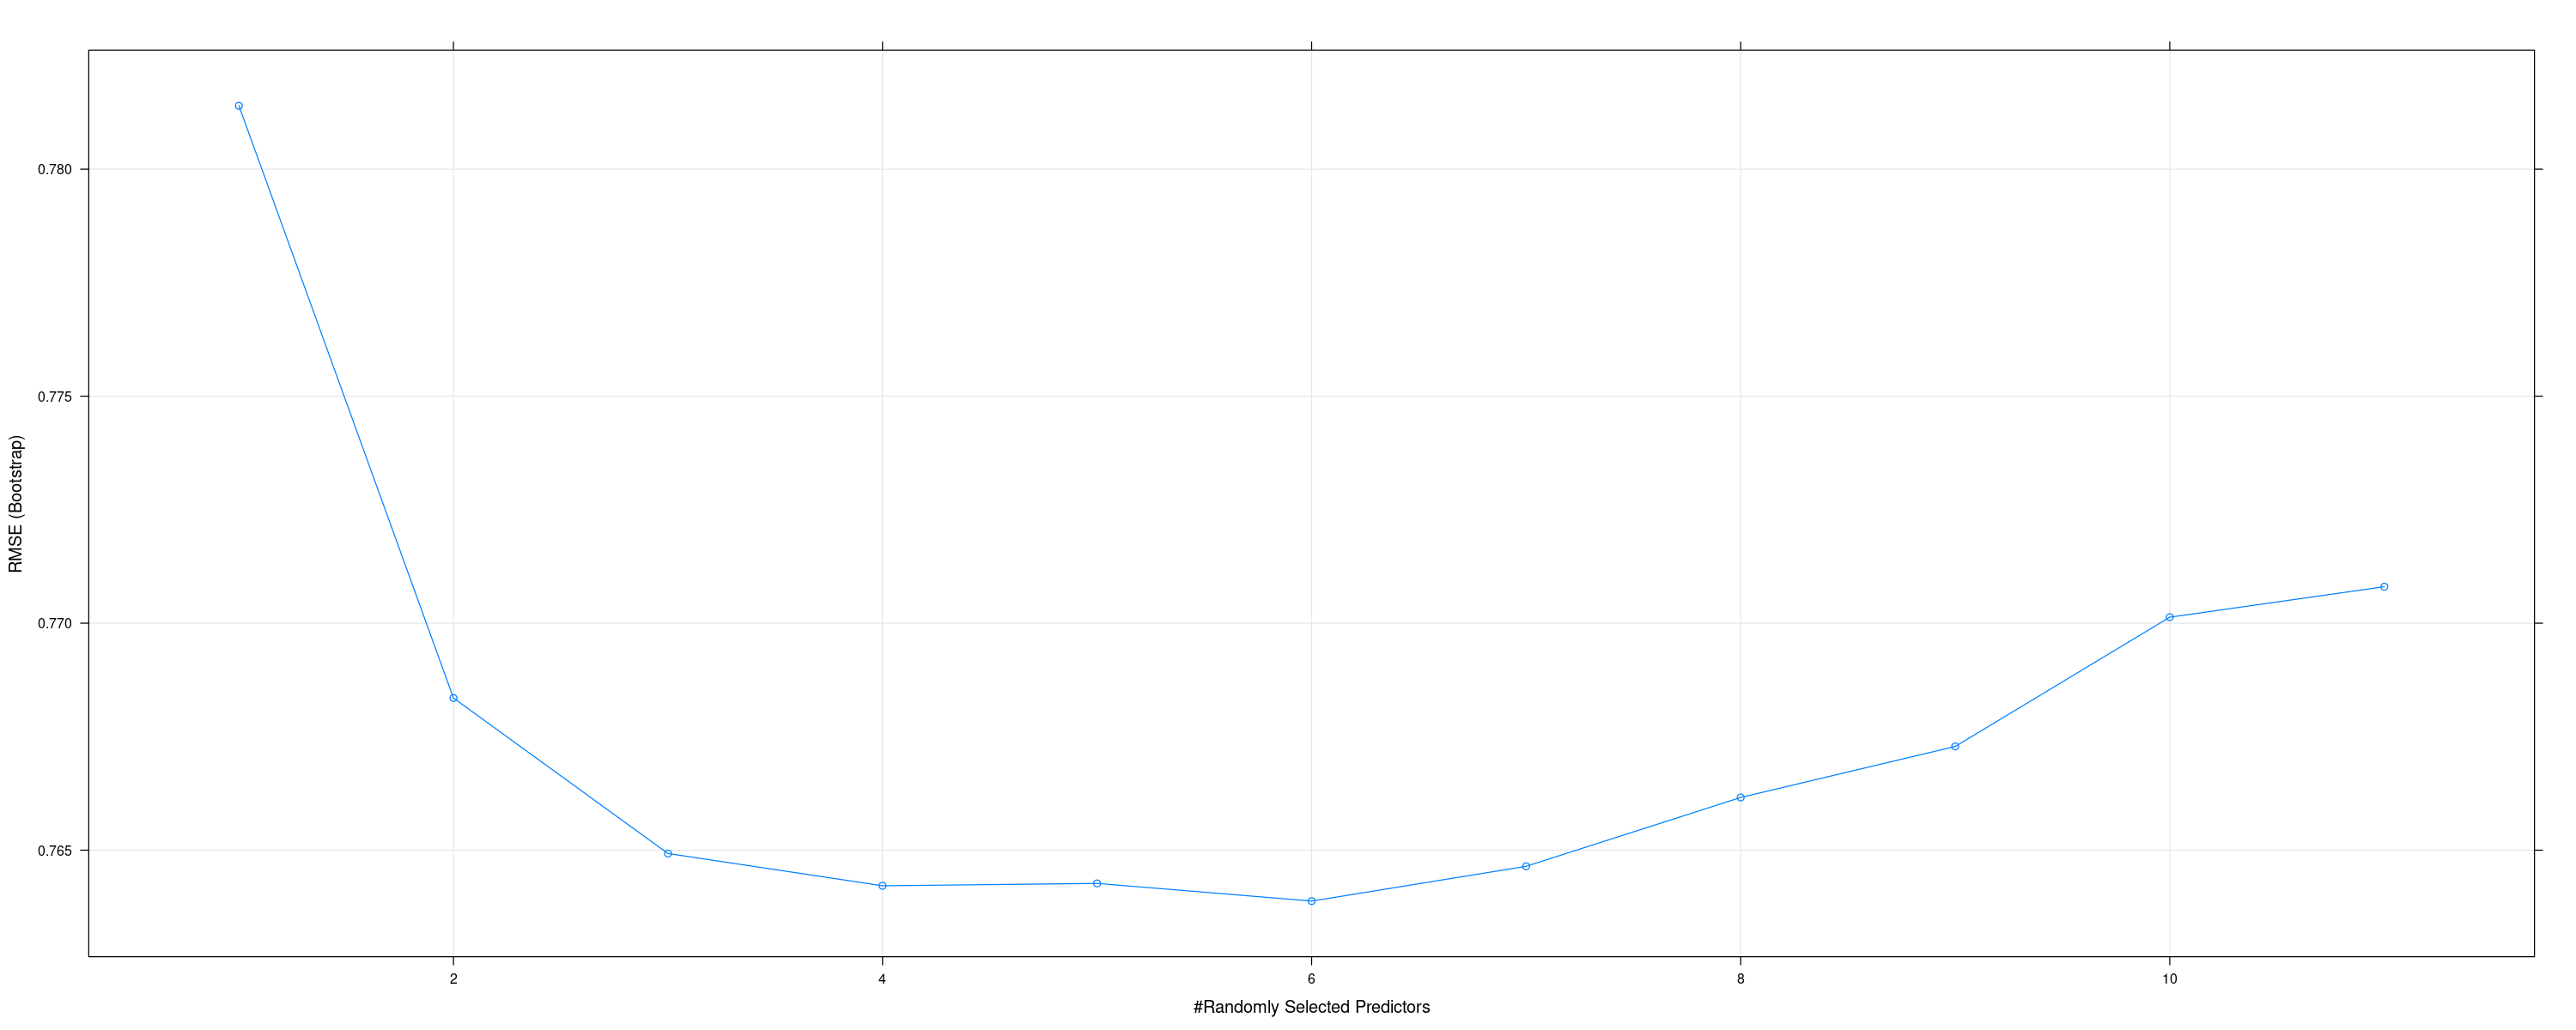

In [7]:
## fitting mtry with caret

rf.caret = train(value ~., df.data, subset = train,
                 method = "rf", ntree = 300,
                 tuneGrid = expand.grid(mtry = 1:11))
plot(rf.caret)

In [ ]:
# Set seed for reproducibility
set.seed(100)

library(doParallel)
cores <- 3
registerDoParallel(cores = cores)

samp <- createDataPartition(df.data$value[train], p = 0.75, list = FALSE)

# Set up the resampling, here repeated CV
tr <- trainControl(method = "repeatedcv", number = 10, repeats = 5)


## fitting with caret
rf.caret = train(value ~., df.data, subset = samp,
                 preProcess = c("center", "scale"),
                 method = "rf", ntree=300,
                 
                 tuneGrid = expand.grid(mtry = 1:11), 
                 trControl=tr
                )

## When you are done:
stopCluster(cores)